In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [4]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std) 
    ])
}

In [5]:
data_dir = "./Projects/Football Athletes Face Recognition/Data/Cleaned Data"

In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}

In [7]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 4) for x in ["train", "val"]}

In [8]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [9]:
class_names = image_datasets["train"].classes

In [10]:
class_names

['Cristiano Ronaldo',
 'Erling Haaland',
 'Kylian Mbappe',
 'Lionel Messi',
 'Neymar Jr']

In [11]:
dataiter = iter(dataloaders["train"])

In [12]:
images, labels = next(dataiter)

In [13]:
def imshow(image):
    image = image.numpy().transpose(1, 2, 0)
    image = (image / 2) + 0.5
    plt.axis("off")
    plt.tight_layout()
    plt.title([class_names[label.item()] for label in labels])
    plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


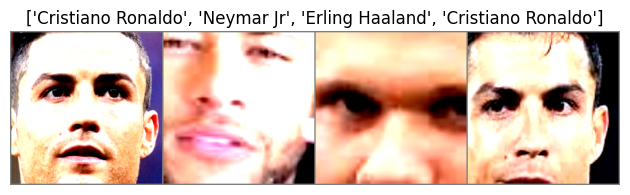

In [14]:
imshow(torchvision.utils.make_grid(images))

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4198 Acc: 0.4160
val Loss: 0.9893 Acc: 0.6533

Epoch 1/24
----------
train Loss: 1.0538 Acc: 0.6120
val Loss: 0.8946 Acc: 0.6683

Epoch 2/24
----------
train Loss: 0.7096 Acc: 0.7520
val Loss: 0.6729 Acc: 0.7538

Epoch 3/24
----------
train Loss: 0.7656 Acc: 0.7260
val Loss: 0.2945 Acc: 0.8945

Epoch 4/24
----------
train Loss: 0.6370 Acc: 0.8000
val Loss: 0.3568 Acc: 0.8995

Epoch 5/24
----------
train Loss: 0.5085 Acc: 0.8080
val Loss: 0.2513 Acc: 0.9095

Epoch 6/24
----------
train Loss: 0.4943 Acc: 0.8200
val Loss: 0.0758 Acc: 0.9598

Epoch 7/24
----------
train Loss: 0.5491 Acc: 0.8140
val Loss: 0.0640 Acc: 0.9749

Epoch 8/24
----------
train Loss: 0.3536 Acc: 0.8640
val Loss: 0.0613 Acc: 0.9849

Epoch 9/24
----------
train Loss: 0.4368 Acc: 0.8560
val Loss: 0.0675 Acc: 0.9799

Epoch 10/24
----------
train Loss: 0.3551 Acc: 0.8920
val Loss: 0.0699 Acc: 0.9799

Epoch 11/24
----------
train Loss: 0.3838 Acc: 0.8740
val Loss: 0.0637 Acc: 0.9849

Ep

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


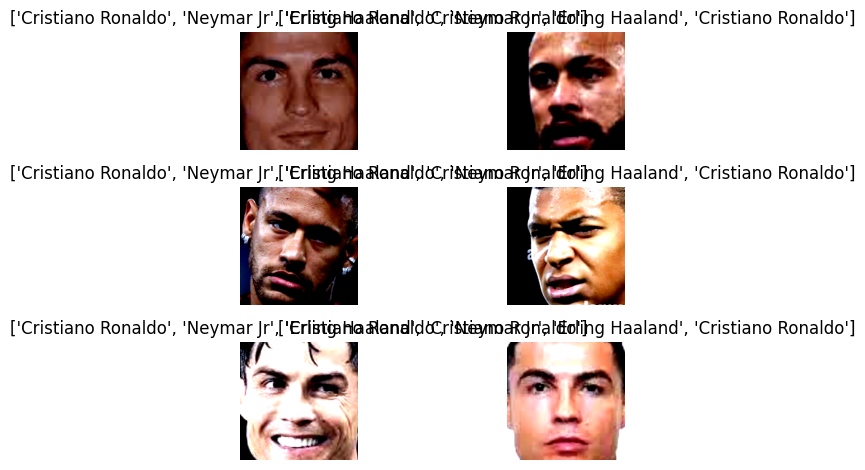

In [21]:
visualize_model(model_ft)
plt.ioff()
plt.show()